<a href="https://colab.research.google.com/github/varshini03/VeriSyn-DeepfakeDetector/blob/main/fakeavfinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Display the contents of the mounted drive
!ls '/content/drive/My Drive'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'Colab Notebooks'	        df_trial.ipynb	 FakeAVCeleb_v1.2       LIPINC-main
'Copy of DeepfakeFinal.ipynb'   FakeAVCeleb	 FakeAVCeleb_v1.2.zip   RESUME_SREE_VARSHINI.pdf


In [ ]:
!ls '/content/drive/My Drive/FakeAVCeleb_v1.2/RealVideo-RealAudio/African/men/id00076'

00109.mp4  00109_roi.mp4  00109_text.txt  00109.wav


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import librosa
from torchvision import transforms
from tensorflow.keras.applications import EfficientNetB0
import os
from tqdm import tqdm
import cv2
import pickle

EXTRACT FEATURES

In [ ]:
def load_video(video_path, num_frames=25):
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total_frames >= num_frames:
        indices = np.round(np.linspace(0, total_frames - 1, num_frames)).astype(int)
        for i in range(total_frames):
            ret, frame = cap.read()
            if i in indices:
                frames.append(frame)
    else:
        for i in range(total_frames):
            ret, frame = cap.read()
            frames.append(frame)
        last_frame = frames[-1]
        for _ in range(num_frames - total_frames):
            frames.append(last_frame)

    cap.release()

    return np.array(frames)

def load_audio(audio_path):
    audio, _ = librosa.load(audio_path, sr=16000)
    return audio

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # Resize to 224x224 for EfficientNet-b0
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize to ImageNet mean and std
])

# Load the pre-trained EfficientNetB0 model without the top classification layer
model = EfficientNetB0(include_top=False, weights='imagenet')

def extract_visual_feature(model, video_path, audio_path):
    frames = load_video(video_path)
    transformed_frames = []
    for frame in frames:
        transformed_frame = transform(frame)
        transformed_frames.append(transformed_frame)
    frames_tensor = torch.stack(transformed_frames)
    frames_tensor = frames_tensor.permute(0, 2, 3, 1)

    audio = load_audio(audio_path)
    audio = torch.tensor(audio)

    # Define the frame length and hop length
    frame_length = 0.025  # Frame length in seconds
    hop_length = 0.01  # Hop length in seconds

    # Convert frame length and hop length to samples
    frame_length_samples = int(frame_length * 16000)  # Use 16000 Hz as the sample rate
    hop_length_samples = int(hop_length * 16000)  # Use 16000 Hz as the sample rate

    # Extract MFCCs for each frame
    mfccs = librosa.feature.mfcc(y=audio.cpu().numpy(), sr=16000, n_mfcc=13, hop_length=hop_length_samples, n_fft=frame_length_samples)
    mfccs = torch.tensor(mfccs)

    # Ensure that the number of frames in the video matches the number of audio frames
    if frames_tensor.shape[0] > mfccs.shape[1]:
        frames_tensor = frames_tensor[:mfccs.shape[1]]
    elif frames_tensor.shape[0] < mfccs.shape[1]:
        mfccs = mfccs[:, :frames_tensor.shape[0]]

    with torch.no_grad():
        feature_vid = model(frames_tensor)
        f = feature_vid.cpu().numpy()

    return f, mfccs.cpu().numpy()

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
print(features,labels)
m = len(features[0])
for i in range(2,100):
  m = min(m,len(features[i]))
print(m)

#features size range - 99-330 for videos

[array([[ -0.21553567,  -0.18586574,  -0.27406168, ...,  -2.1479392 ,
         -2.4439921 ,  -6.1380043 ],
       [ -0.21546914,  -0.18583944,  -0.2740537 , ..., -15.189792  ,
         -2.4071355 ,  -5.828635  ],
       [ -0.21551767,  -0.18586908,  -0.27406144, ...,  -8.657143  ,
          4.2383466 ,  -8.901952  ],
       ...,
       [ -0.21754555,  -0.18661118,  -0.27354473, ..., -21.95414   ,
          1.2516623 ,   1.9154036 ],
       [ -0.21719456,  -0.1859487 ,  -0.2738531 , ..., -13.920692  ,
         -1.7427645 ,  -4.8499384 ],
       [ -0.2173499 ,  -0.18592262,  -0.2737749 , ...,  -9.577986  ,
          3.811412  ,  -9.51008   ]], dtype=float32), array([[ -0.21770109,  -0.18762659,  -0.27298993, ...,  26.717709  ,
        -10.423573  ,  -8.19199   ],
       [ -0.21776144,  -0.18757893,  -0.27302977, ...,  29.012604  ,
         -5.971885  , -15.933817  ],
       [ -0.21787204,  -0.18746176,  -0.2730927 , ...,   7.0961704 ,
         -4.6348042 , -12.784122  ],
       ...,
    

FEATURE EXTRACTION FOR RVRA

In [ ]:
from sklearn.decomposition import PCA
# Initialize an empty list for storing the features and labels
features = []
labels = []

# Directory walk
PATH_TO_DIRECTORY = '/content/drive/My Drive/FakeAVCeleb_v1.2/'
categories = ['rvra']#, 'rvfa', 'fvra', 'fvfa']

for category in categories:
    if category == 'rvra':
        input_root = os.path.join(PATH_TO_DIRECTORY, 'RealVideo-RealAudio')
        label = 0
    else:
        if category == 'rvfa':
            input_root = os.path.join(PATH_TO_DIRECTORY, 'RealVideo-FakeAudio')
        elif category == 'fvra':
            input_root = os.path.join(PATH_TO_DIRECTORY, 'FakeVideo-RealAudio')
        elif category == 'fvfa':
            input_root = os.path.join(PATH_TO_DIRECTORY, 'FakeVideo-FakeAudio')
        label = 1

    to_iterate = list(os.walk(input_root))
    for root, dirs, files in tqdm(to_iterate, total=len(to_iterate)):
        for file in files:
            if file.endswith('_roi.mp4'):
                input_video_path = os.path.join(root, file)
                input_audio_path = os.path.join(root, file[:-8] + '.wav')

                # Extract the features
                f, mfccs = extract_visual_feature(model, input_video_path, input_audio_path)
                # Reduce dimensions of f
                f = f.reshape((f.shape[0], -1))  # Reshape f to 2D

                # Concatenate the features and add them to the list
                features.append(np.concatenate([f, mfccs.T], axis=-1))

                # Add the label to the list
                labels.append(label)


  0%|          | 0/104 [00:00<?, ?it/s]WARNING:tensorflow:From <ipython-input-2-b4a4e6da3e48>:70: _EagerTensorBase.cpu (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.identity with explicit device placement instead.
100%|██████████| 104/104 [02:34<00:00,  1.49s/it]


In [ ]:
print(len(features))
print(len(labels))
print(f.shape,mfccs.shape)
m = len(features[0])
for i in range(2,100):
  m = max(m,len(features[i]))
print(m)

100
100
(25, 62720) (13, 25)
25


In [ ]:
# save as .npy file
features = np.array(features)
labels = np.array(labels)
np.save('/content/drive/My Drive/FakeAVCeleb_v1.2/rvra_features.npy', features)
np.save('/content/drive/My Drive/FakeAVCeleb_v1.2/rvra_labels.npy', labels)

In [ ]:
# load from .npy file
features1 = np.load('/content/drive/My Drive/FakeAVCeleb_v1.2/rvra_features.npy')
labels1 = np.load('/content/drive/My Drive/FakeAVCeleb_v1.2/rvra_labels.npy')

print(features1,labels1)

[[[ -0.21553579  -0.18586577  -0.27406168 ...  -2.1479392   -2.4439921
    -6.1380043 ]
  [ -0.21717408  -0.18545711  -0.2738458  ... -15.189792    -2.4071355
    -5.828635  ]
  [ -0.21702646  -0.18577763  -0.27365077 ...  -8.657143     4.2383466
    -8.901952  ]
  ...
  [ -0.21769507  -0.1866018   -0.2733513  ... -19.404577    -6.9667172
    -3.2468657 ]
  [ -0.21702123  -0.18655275  -0.2735521  ... -12.477049    -3.766316
   -22.216078  ]
  [ -0.21734981  -0.18592286  -0.2737749  ...  -8.677618   -13.669761
   -14.910971  ]]

 [[ -0.2177013   -0.18762615  -0.27298996 ...  26.717709   -10.423573
    -8.19199   ]
  [ -0.2177653   -0.1874231   -0.27306172 ...  29.012604    -5.971885
   -15.933817  ]
  [ -0.21873234  -0.1877257   -0.27307072 ...   7.0961704   -4.6348042
   -12.784122  ]
  ...
  [ -0.21810095  -0.1873014   -0.27304578 ...   4.3850465  -16.282429
    31.894953  ]
  [ -0.21784416  -0.18727642  -0.27310327 ...  15.468962    -7.090953
    11.709892  ]
  [ -0.21794495  -0.1873

FEATURE EXTRACTION FOR FVRA

In [ ]:
from sklearn.decomposition import PCA
# Initialize an empty list for storing the features and labels
features = []
labels = []

# Directory walk
PATH_TO_DIRECTORY = '/content/drive/My Drive/FakeAVCeleb_v1.2/'
categories = ['rvfa']#, 'rvfa', 'fvra', 'fvfa']

for category in categories:
    if category == 'rvra':
        input_root = os.path.join(PATH_TO_DIRECTORY, 'RealVideo-RealAudio')
        label = 0
    else:
        if category == 'rvfa':
            input_root = os.path.join(PATH_TO_DIRECTORY, 'RealVideo-FakeAudio')
        elif category == 'fvra':
            input_root = os.path.join(PATH_TO_DIRECTORY, 'FakeVideo-RealAudio')
        elif category == 'fvfa':
            input_root = os.path.join(PATH_TO_DIRECTORY, 'FakeVideo-FakeAudio')
        label = 1

    to_iterate = list(os.walk(input_root))
    for root, dirs, files in tqdm(to_iterate, total=len(to_iterate)):
        for file in files:
            if file.endswith('_roi.mp4'):
                input_video_path = os.path.join(root, file)
                input_audio_path = os.path.join(root, file[:-8] + '.wav')

                # Extract the features
                f, mfccs = extract_visual_feature(model, input_video_path, input_audio_path)
                # Reduce dimensions of f
                f = f.reshape((f.shape[0], -1))  # Reshape f to 2D

                # Concatenate the features and add them to the list
                features.append(np.concatenate([f, mfccs.T], axis=-1))

                # Add the label to the list
                labels.append(label)


100%|██████████| 104/104 [02:11<00:00,  1.27s/it]


In [ ]:
# save as .npy file
features = np.array(features)
labels = np.array(labels)
np.save('/content/drive/My Drive/FakeAVCeleb_v1.2/rvfa_features.npy', features)
np.save('/content/drive/My Drive/FakeAVCeleb_v1.2/rvfa_labels.npy', labels)

In [ ]:
print(len(features))
print(len(labels))
print(f.shape,mfccs.shape)

100
100
(25, 62720) (13, 25)


FEATURE EXTRACTION FOR FVRA

In [ ]:
from sklearn.decomposition import PCA
# Initialize an empty list for storing the features and labels
features = []
labels = []

# Directory walk
PATH_TO_DIRECTORY = '/content/drive/My Drive/FakeAVCeleb_v1.2/'
categories = ['fvra']#, 'rvfa', 'fvra', 'fvfa']

for category in categories:
    if category == 'rvra':
        input_root = os.path.join(PATH_TO_DIRECTORY, 'RealVideo-RealAudio')
        label = 0
    else:
        if category == 'rvfa':
            input_root = os.path.join(PATH_TO_DIRECTORY, 'RealVideo-FakeAudio')
        elif category == 'fvra':
            input_root = os.path.join(PATH_TO_DIRECTORY, 'FakeVideo-RealAudio')
        elif category == 'fvfa':
            input_root = os.path.join(PATH_TO_DIRECTORY, 'FakeVideo-FakeAudio')
        label = 1

    to_iterate = list(os.walk(input_root))
    for root, dirs, files in tqdm(to_iterate, total=len(to_iterate)):
        for file in files:
            if file.endswith('_roi.mp4'):
                input_video_path = os.path.join(root, file)
                input_audio_path = os.path.join(root, file[:-8] + '.wav')

                # Extract the features
                f, mfccs = extract_visual_feature(model, input_video_path, input_audio_path)
                # Reduce dimensions of f
                f = f.reshape((f.shape[0], -1))  # Reshape f to 2D

                # Concatenate the features and add them to the list
                features.append(np.concatenate([f, mfccs.T], axis=-1))

                # Add the label to the list
                labels.append(label)


100%|██████████| 104/104 [41:45<00:00, 24.09s/it]


In [ ]:
# save as .npy file
features = np.array(features)
labels = np.array(labels)
np.save('/content/drive/My Drive/FakeAVCeleb_v1.2/fvra_features.npy', features)
np.save('/content/drive/My Drive/FakeAVCeleb_v1.2/fvra_labels.npy', labels)

In [ ]:
print(len(features))
print(len(labels))
print(f.shape,mfccs.shape)

1850
1850
(25, 62720) (13, 25)


In [ ]:
# load from .npy file
features1 = np.load('/content/drive/My Drive/FakeAVCeleb_v1.2/fvra_features.npy')
labels1 = np.load('/content/drive/My Drive/FakeAVCeleb_v1.2/fvra_labels.npy')

print(features1,labels1)

[[[ -0.21728443  -0.19065866  -0.27191392 ... -10.287678    -0.14026248
    -3.7251348 ]
  [ -0.21817164  -0.18941824  -0.2710543  ... -20.641937     8.833809
   -25.49377   ]
  [ -0.21714823  -0.18814705  -0.27183825 ... -29.714558     8.040483
   -24.030323  ]
  ...
  [ -0.21669826  -0.19112398  -0.27103022 ...  -1.3236544    5.4852724
    -1.7872348 ]
  [ -0.215456    -0.18848853  -0.272555   ...  -7.2609434    3.038221
    -4.0209837 ]
  [ -0.21739426  -0.18750349  -0.27221847 ... -12.209359    -2.3402333
    -9.747793  ]]

 [[ -0.21479568  -0.1903256   -0.27273187 ...  -0.15268016  -5.0622764
     3.0150015 ]
  [ -0.21757075  -0.18862225  -0.2713449  ...   8.961884   -12.80596
    -9.166618  ]
  [ -0.21736713  -0.18775465  -0.27207556 ...   9.325798   -11.102903
   -13.603825  ]
  ...
  [ -0.2164418   -0.18834154  -0.2720047  ...  -0.11887956  -4.178855
     8.68233   ]
  [ -0.21776704  -0.18647313  -0.27305818 ...  10.518613     6.9844866
    -9.319471  ]
  [ -0.21486965  -0.1868

In [ ]:
from sklearn.decomposition import PCA
# Initialize an empty list for storing the features and labels
features = []
labels = []

# Directory walk
PATH_TO_DIRECTORY = '/content/drive/My Drive/FakeAVCeleb_v1.2/'
categories = ['fvfa']#, 'rvfa', 'fvra', 'fvfa']

for category in categories:
    if category == 'rvra':
        input_root = os.path.join(PATH_TO_DIRECTORY, 'RealVideo-RealAudio')
        label = 0
    else:
        if category == 'rvfa':
            input_root = os.path.join(PATH_TO_DIRECTORY, 'RealVideo-FakeAudio')
        elif category == 'fvra':
            input_root = os.path.join(PATH_TO_DIRECTORY, 'FakeVideo-RealAudio')
        elif category == 'fvfa':
            input_root = os.path.join(PATH_TO_DIRECTORY, 'FakeVideo-FakeAudio')
        label = 1

    to_iterate = list(os.walk(input_root))
    for root, dirs, files in tqdm(to_iterate, total=len(to_iterate)):
        for file in files:
            if file.endswith('_roi.mp4'):
                input_video_path = os.path.join(root, file)
                input_audio_path = os.path.join(root, file[:-8] + '.wav')

                # Extract the features
                f, mfccs = extract_visual_feature(model, input_video_path, input_audio_path)
                # Reduce dimensions of f
                f = f.reshape((f.shape[0], -1))  # Reshape f to 2D

                # Concatenate the features and add them to the list
                features.append(np.concatenate([f, mfccs.T], axis=-1))

                # Add the label to the list
                labels.append(label)


In [ ]:
# save as .npy file
features = np.array(features)
labels = np.array(labels)
np.save('/content/drive/My Drive/FakeAVCeleb_v1.2/fvfa_features.npy', features)
np.save('/content/drive/My Drive/FakeAVCeleb_v1.2/fvfa_labels.npy', labels)

LOADING TO PICKLE - LATER STARTED USING .npy FILES

In [ ]:
import pickle
# Load the data
with open('/content/drive/My Drive/rvra_labels.pkl', 'rb') as f1:
    rvra_labels = pickle.load(f1)

In [ ]:
print(rvra_labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
import pickle
# Load the data
with open('/content/drive/My Drive/rvfa_labels.pkl', 'rb') as f1:
    rvfa_labels = pickle.load(f1)
print(rvfa_labels)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
import pickle
# Load the data
with open('/content/drive/My Drive/fvra_labels.pkl', 'rb') as f1:
    fvra_labels = pickle.load(f1)
print(fvra_labels)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
from numpy import savetxt
savetxt('data.csv', rvfa_features, delimiter=',')

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (100,) + inhomogeneous part.

In [ ]:
print(rvra_features[-1]s.shape)
print(rvfa_features[-1]shape)
print(fvra_features[-1].shape)
print()
print(rvra_feature[0]s.shape)
print(rvfa_features[0]shape)
print(fvra_features[0].shape)

In [ ]:
import pickle
# Load the data
with open('/content/drive/My Drive/fvra_features.pkl', 'rb') as f1:
    fvra_features = pickle.load(f1)
print(fvra_features)

UnpicklingError: pickle data was truncated

NORMALISE EXTRACTED FEATURES

In [ ]:
# load from .npy file
features1 = np.load('/content/drive/My Drive/FakeAVCeleb_v1.2/rvra_features.npy')
labels1 = np.load('/content/drive/My Drive/FakeAVCeleb_v1.2/rvra_labels.npy')

print(features1,labels1)

[[[ -0.21553579  -0.18586577  -0.27406168 ...  -2.1479392   -2.4439921
    -6.1380043 ]
  [ -0.21717408  -0.18545711  -0.2738458  ... -15.189792    -2.4071355
    -5.828635  ]
  [ -0.21702646  -0.18577763  -0.27365077 ...  -8.657143     4.2383466
    -8.901952  ]
  ...
  [ -0.21769507  -0.1866018   -0.2733513  ... -19.404577    -6.9667172
    -3.2468657 ]
  [ -0.21702123  -0.18655275  -0.2735521  ... -12.477049    -3.766316
   -22.216078  ]
  [ -0.21734981  -0.18592286  -0.2737749  ...  -8.677618   -13.669761
   -14.910971  ]]

 [[ -0.2177013   -0.18762615  -0.27298996 ...  26.717709   -10.423573
    -8.19199   ]
  [ -0.2177653   -0.1874231   -0.27306172 ...  29.012604    -5.971885
   -15.933817  ]
  [ -0.21873234  -0.1877257   -0.27307072 ...   7.0961704   -4.6348042
   -12.784122  ]
  ...
  [ -0.21810095  -0.1873014   -0.27304578 ...   4.3850465  -16.282429
    31.894953  ]
  [ -0.21784416  -0.18727642  -0.27310327 ...  15.468962    -7.090953
    11.709892  ]
  [ -0.21794495  -0.1873

In [ ]:
# load from .npy file
features2 = np.load('/content/drive/My Drive/FakeAVCeleb_v1.2/rvfa_features.npy')
labels2 = np.load('/content/drive/My Drive/FakeAVCeleb_v1.2/rvfa_labels.npy')

print(features2,labels2)

[[[ -0.21757841  -0.18817836  -0.2736114  ...   0.           0.
     0.        ]
  [ -0.21772477  -0.19064349  -0.27374625 ...   0.           0.
     0.        ]
  [ -0.21816446  -0.19171053  -0.2737062  ...  -2.834505     4.229445
    12.29057   ]
  ...
  [ -0.24251084  -0.22180621  -0.26278153 ...  -7.030238   -10.220714
   -12.40023   ]
  [ -0.21909036  -0.18876904  -0.2750663  ...   0.66008306 -16.7221
   -12.24515   ]
  [ -0.2206081   -0.19069345  -0.27509156 ...   2.3798811  -15.372645
   -10.739261  ]]

 [[ -0.21261404  -0.18827984  -0.27290156 ...   0.           0.
     0.        ]
  [ -0.20411351  -0.18468861  -0.2708256  ...   0.           0.
     0.        ]
  [ -0.21148792  -0.18783541  -0.27277687 ...   0.           0.
     0.        ]
  ...
  [ -0.21206558  -0.18955891  -0.27319682 ... -14.838175     0.12730569
    -6.717118  ]
  [ -0.2124617   -0.18903728  -0.27297857 ... -31.65903    -18.527908
   -13.68387   ]
  [ -0.21206735  -0.18907695  -0.27310067 ... -25.28479    

In [ ]:
# load from .npy file
features3 = np.load('/content/drive/My Drive/FakeAVCeleb_v1.2/fvra_features.npy')
labels3 = np.load('/content/drive/My Drive/FakeAVCeleb_v1.2/fvra_labels.npy')

print(features3,labels3)

[[[ -0.21728443  -0.19065866  -0.27191392 ... -10.287678    -0.14026248
    -3.7251348 ]
  [ -0.21817164  -0.18941824  -0.2710543  ... -20.641937     8.833809
   -25.49377   ]
  [ -0.21714823  -0.18814705  -0.27183825 ... -29.714558     8.040483
   -24.030323  ]
  ...
  [ -0.21669826  -0.19112398  -0.27103022 ...  -1.3236544    5.4852724
    -1.7872348 ]
  [ -0.215456    -0.18848853  -0.272555   ...  -7.2609434    3.038221
    -4.0209837 ]
  [ -0.21739426  -0.18750349  -0.27221847 ... -12.209359    -2.3402333
    -9.747793  ]]

 [[ -0.21479568  -0.1903256   -0.27273187 ...  -0.15268016  -5.0622764
     3.0150015 ]
  [ -0.21757075  -0.18862225  -0.2713449  ...   8.961884   -12.80596
    -9.166618  ]
  [ -0.21736713  -0.18775465  -0.27207556 ...   9.325798   -11.102903
   -13.603825  ]
  ...
  [ -0.2164418   -0.18834154  -0.2720047  ...  -0.11887956  -4.178855
     8.68233   ]
  [ -0.21776704  -0.18647313  -0.27305818 ...  10.518613     6.9844866
    -9.319471  ]
  [ -0.21486965  -0.1868

In [ ]:
from sklearn.preprocessing import MinMaxScaler

f_shape = features1.shape

# Create a scaler
scaler = MinMaxScaler(feature_range=(-1, 1))

# Normalize f
f_2d = features1.reshape(f_shape[0], -1)
f_2d_norm = scaler.fit_transform(f_2d)
f_norm = f_2d_norm.reshape(f_shape)

print(f_norm)

[[[-0.17952728  0.7270508  -0.90842056 ... -0.13993445  0.2564427
   -0.1856009 ]
  [ 0.17400551  0.9173269  -0.58120346 ... -0.27951315  0.11598359
   -0.0171487 ]
  [ 0.07205105  0.80475616 -0.9153271  ... -0.16625229  0.02992421
   -0.01649746]
  ...
  [ 0.5176773   0.7520256  -0.6635895  ... -0.44608897 -0.00442326
   -0.00634465]
  [ 0.3361473   0.05308914 -0.5646744  ... -0.31095365  0.04466207
   -0.5722969 ]
  [-0.17365074 -0.06860256 -0.5658531  ... -0.19434725 -0.15073305
   -0.4530009 ]]

 [[-0.33986473  0.41796112 -0.8489647  ...  1.0000001  -0.02247542
   -0.26992002]
  [ 0.13742256  0.7708683  -0.47097778 ...  0.9999999   0.01531498
   -0.30908704]
  [-0.01046085  0.6414585  -0.89472866 ...  0.3298393  -0.23360857
   -0.12144038]
  ...
  [ 0.4900093   0.7141342  -0.6282215  ...  0.22133371 -0.2974981
    0.9999999 ]
  [ 0.24599075 -0.01585579 -0.4993286  ...  0.43664286 -0.06366073
    0.58629775]
  [-0.20521069 -0.17724705 -0.47608566 ...  0.62693274  0.02174278
    0.14

In [ ]:
features1 = f_norm

In [ ]:
print(features1)

[[[-0.17952728  0.7270508  -0.90842056 ... -0.13993445  0.2564427
   -0.1856009 ]
  [ 0.17400551  0.9173269  -0.58120346 ... -0.27951315  0.11598359
   -0.0171487 ]
  [ 0.07205105  0.80475616 -0.9153271  ... -0.16625229  0.02992421
   -0.01649746]
  ...
  [ 0.5176773   0.7520256  -0.6635895  ... -0.44608897 -0.00442326
   -0.00634465]
  [ 0.3361473   0.05308914 -0.5646744  ... -0.31095365  0.04466207
   -0.5722969 ]
  [-0.17365074 -0.06860256 -0.5658531  ... -0.19434725 -0.15073305
   -0.4530009 ]]

 [[-0.33986473  0.41796112 -0.8489647  ...  1.0000001  -0.02247542
   -0.26992002]
  [ 0.13742256  0.7708683  -0.47097778 ...  0.9999999   0.01531498
   -0.30908704]
  [-0.01046085  0.6414585  -0.89472866 ...  0.3298393  -0.23360857
   -0.12144038]
  ...
  [ 0.4900093   0.7141342  -0.6282215  ...  0.22133371 -0.2974981
    0.9999999 ]
  [ 0.24599075 -0.01585579 -0.4993286  ...  0.43664286 -0.06366073
    0.58629775]
  [-0.20521069 -0.17724705 -0.47608566 ...  0.62693274  0.02174278
    0.14

In [ ]:
print(features1.shape)

(100, 25, 62733)


In [ ]:
# load from .npy file
fc = np.load('/content/drive/My Drive/FakeAVCeleb_v1.2/rvra_features.npy')
lc = np.load('/content/drive/My Drive/FakeAVCeleb_v1.2/rvra_labels.npy')

print(fc.shape)
print(fc)

(100, 25, 62733)
[[[ -0.21553579  -0.18586577  -0.27406168 ...  -2.1479392   -2.4439921
    -6.1380043 ]
  [ -0.21717408  -0.18545711  -0.2738458  ... -15.189792    -2.4071355
    -5.828635  ]
  [ -0.21702646  -0.18577763  -0.27365077 ...  -8.657143     4.2383466
    -8.901952  ]
  ...
  [ -0.21769507  -0.1866018   -0.2733513  ... -19.404577    -6.9667172
    -3.2468657 ]
  [ -0.21702123  -0.18655275  -0.2735521  ... -12.477049    -3.766316
   -22.216078  ]
  [ -0.21734981  -0.18592286  -0.2737749  ...  -8.677618   -13.669761
   -14.910971  ]]

 [[ -0.2177013   -0.18762615  -0.27298996 ...  26.717709   -10.423573
    -8.19199   ]
  [ -0.2177653   -0.1874231   -0.27306172 ...  29.012604    -5.971885
   -15.933817  ]
  [ -0.21873234  -0.1877257   -0.27307072 ...   7.0961704   -4.6348042
   -12.784122  ]
  ...
  [ -0.21810095  -0.1873014   -0.27304578 ...   4.3850465  -16.282429
    31.894953  ]
  [ -0.21784416  -0.18727642  -0.27310327 ...  15.468962    -7.090953
    11.709892  ]
  [ -0.

In [ ]:
# save as .npy file
features = np.array(features1)
print(features.shape)
np.save('/content/drive/My Drive/FakeAVCeleb_v1.2/rvra_features.npy', features)

(100, 25, 62733)


In [ ]:
# load from .npy file
fc = np.load('/content/drive/My Drive/FakeAVCeleb_v1.2/rvra_features.npy')

print(fc)

[[[-0.17952728  0.7270508  -0.90842056 ... -0.13993445  0.2564427
   -0.1856009 ]
  [ 0.17400551  0.9173269  -0.58120346 ... -0.27951315  0.11598359
   -0.0171487 ]
  [ 0.07205105  0.80475616 -0.9153271  ... -0.16625229  0.02992421
   -0.01649746]
  ...
  [ 0.5176773   0.7520256  -0.6635895  ... -0.44608897 -0.00442326
   -0.00634465]
  [ 0.3361473   0.05308914 -0.5646744  ... -0.31095365  0.04466207
   -0.5722969 ]
  [-0.17365074 -0.06860256 -0.5658531  ... -0.19434725 -0.15073305
   -0.4530009 ]]

 [[-0.33986473  0.41796112 -0.8489647  ...  1.0000001  -0.02247542
   -0.26992002]
  [ 0.13742256  0.7708683  -0.47097778 ...  0.9999999   0.01531498
   -0.30908704]
  [-0.01046085  0.6414585  -0.89472866 ...  0.3298393  -0.23360857
   -0.12144038]
  ...
  [ 0.4900093   0.7141342  -0.6282215  ...  0.22133371 -0.2974981
    0.9999999 ]
  [ 0.24599075 -0.01585579 -0.4993286  ...  0.43664286 -0.06366073
    0.58629775]
  [-0.20521069 -0.17724705 -0.47608566 ...  0.62693274  0.02174278
    0.14

In [ ]:
f_shape2 = features2.shape

f_2d2 = features2.reshape(f_shape[0], -1)
f_2d_norm2 = scaler.fit_transform(f_2d2)
f_norm2 = f_2d_norm2.reshape(f_shape2)

print(f_norm2)

[[[-2.88436890e-01  2.84343719e-01 -8.65087509e-01 ... -1.00000000e+00
   -1.00000000e+00 -1.00000000e+00]
  [ 1.76734924e-02  3.52600098e-01 -5.71769714e-01 ... -1.00000000e+00
   -1.00000000e+00 -1.00000000e+00]
  [-2.04038620e-02  2.83365250e-01 -8.75297546e-01 ... -1.81770518e-01
    6.03618920e-02  4.91243720e-01]
  ...
  [-1.00000000e+00 -1.00000000e+00  5.97433090e-01 ... -3.35397005e-01
   -3.54240477e-01 -2.32526511e-01]
  [ 4.24141884e-01 -2.41369247e-01 -7.90744781e-01 ...  1.22896813e-01
   -5.55469036e-01 -1.99319899e-01]
  [-3.16061974e-01 -4.35498238e-01 -6.96739197e-01 ...  2.72763968e-01
   -5.35468817e-01 -1.87190086e-01]]

 [[ 1.05125427e-01  2.66181946e-01 -8.19835663e-01 ... -1.00000000e+00
   -1.00000000e+00 -1.00000000e+00]
  [ 1.00000095e+00  8.88113022e-01 -1.38248444e-01 ... -1.00000000e+00
   -1.00000000e+00 -1.00000000e+00]
  [ 3.58452797e-01  6.18160248e-01 -8.31769943e-01 ...  4.22954559e-02
   -2.69483924e-01 -5.18760681e-01]
  ...
  [ 6.47973061e-01  6.6

In [ ]:
# load from .npy file
fc2 = np.load('/content/drive/My Drive/FakeAVCeleb_v1.2/rvfa_features.npy')
lc2 = np.load('/content/drive/My Drive/FakeAVCeleb_v1.2/rvfa_labels.npy')

print(fc2.shape)
print(fc2)

(100, 25, 62733)
[[[ -0.21757841  -0.18817836  -0.2736114  ...   0.           0.
     0.        ]
  [ -0.21772477  -0.19064349  -0.27374625 ...   0.           0.
     0.        ]
  [ -0.21816446  -0.19171053  -0.2737062  ...  -2.834505     4.229445
    12.29057   ]
  ...
  [ -0.24251084  -0.22180621  -0.26278153 ...  -7.030238   -10.220714
   -12.40023   ]
  [ -0.21909036  -0.18876904  -0.2750663  ...   0.66008306 -16.7221
   -12.24515   ]
  [ -0.2206081   -0.19069345  -0.27509156 ...   2.3798811  -15.372645
   -10.739261  ]]

 [[ -0.21261404  -0.18827984  -0.27290156 ...   0.           0.
     0.        ]
  [ -0.20411351  -0.18468861  -0.2708256  ...   0.           0.
     0.        ]
  [ -0.21148792  -0.18783541  -0.27277687 ...   0.           0.
     0.        ]
  ...
  [ -0.21206558  -0.18955891  -0.27319682 ... -14.838175     0.12730569
    -6.717118  ]
  [ -0.2124617   -0.18903728  -0.27297857 ... -31.65903    -18.527908
   -13.68387   ]
  [ -0.21206735  -0.18907695  -0.27310067 

In [ ]:
features2 = f_norm2
# save as .npy file
features = np.array(features2)
print(features.shape)
np.save('/content/drive/My Drive/FakeAVCeleb_v1.2/rvfa_features.npy', features)

(100, 25, 62733)


In [ ]:
f_shape3 = features3.shape

f_2d3 = features3.reshape(f_shape3[0], -1)
f_2d_norm3 = scaler.fit_transform(f_2d3)
f_norm3 = f_2d_norm3.reshape(f_shape3)

print(f_norm3)

[[[-0.45003796  0.21230125 -0.7818556  ... -0.4030553   0.21940936
    0.04989316]
  [ 0.12524414  0.44643116 -0.46552277 ... -0.43733472  0.36734313
   -0.47842765]
  [ 0.05436325  0.59883976 -0.77150726 ... -0.74561745  0.11390406
   -0.3464042 ]
  ...
  [ 0.28573418  0.75104284 -0.82909775 ...  0.1036524   0.256652
    0.04553828]
  [ 0.5361204   0.42758083 -0.62916756 ... -0.10568325  0.17749491
    0.07214069]
  [ 0.36461258  0.55227804 -0.7549715  ... -0.2619584   0.12811372
   -0.17834693]]

 [[-0.2675724   0.24370384 -0.81840897 ... -0.02392392  0.062493
    0.3163016 ]
  [ 0.16543579  0.49206257 -0.49119377 ...  0.41959792 -0.2139622
   -0.04089205]
  [ 0.04389286  0.6236124  -0.7809038  ...  0.4295082  -0.41664124
   -0.08105597]
  ...
  [ 0.2956524   0.8069246  -0.8554554  ...  0.1359233  -0.01874784
    0.34221733]
  [ 0.44482708  0.51072264 -0.66960335 ...  0.34325662  0.29602918
   -0.09613782]
  [ 0.43701887  0.5701275  -0.7963629  ...  0.3306499   0.17437617
   -0.18402

In [ ]:
features3 = f_norm3
# save as .npy file
features = np.array(features3)
print(features.shape)
np.save('/content/drive/My Drive/FakeAVCeleb_v1.2/fvra_features.npy', features)

(1850, 25, 62733)


MODEL TRAINING

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np

In [ ]:
# load from .npy file
rvra_features = np.load('/content/drive/My Drive/FakeAVCeleb_v1.2/rvra_features.npy')
rvra_labels = np.load('/content/drive/My Drive/FakeAVCeleb_v1.2/rvra_labels.npy')

rvfa_features = np.load('/content/drive/My Drive/FakeAVCeleb_v1.2/rvfa_features.npy')
rvfa_labels = np.load('/content/drive/My Drive/FakeAVCeleb_v1.2/rvfa_labels.npy')

fvra_features = np.load('/content/drive/My Drive/FakeAVCeleb_v1.2/fvra_features.npy')
fvra_labels = np.load('/content/drive/My Drive/FakeAVCeleb_v1.2/fvra_labels.npy')


In [ ]:
print(rvra_features.shape, rvra_labels.shape)

(100, 25, 62733) (100,)


In [ ]:
# Combine the features and labels
features = np.concatenate((rvra_features, rvfa_features, fvra_features), axis=0)
labels = np.concatenate((rvra_labels, rvfa_labels, fvra_labels), axis=0)

# Shuffle the data
indices = np.arange(features.shape[0])
np.random.shuffle(indices)

features = features[indices]
labels = labels[indices]

# Split the data into training and testing sets
#features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2, random_state=42)



In [ ]:
!pip install -U imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 2.1 MB/s eta 0:00:00


handling imbalance in dataset

In [ ]:
from imblearn.over_sampling import RandomOverSampler
import numpy as np

# Save the original shape
original_shape = features.shape

# Flatten your data into 2D
features_flattened = features.reshape(features.shape[0], -1)

# Define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='auto')

# Fit and apply the transform
features_over, labels_over = oversample.fit_resample(features_flattened, labels)

# Reshape the data back to its original shape
features_over = features_over.reshape(-1, *original_shape[1:])


In [ ]:
# Split the data into training and testing sets
features_train, features_test, labels_train, labels_test = train_test_split(features_over, labels_over, test_size=0.2, random_state=42)


In [ ]:
np.save('features_over.npy', features_over)
np.save('labels_over.npy', labels_over)

In [ ]:
from collections import Counter

# Assuming labels_over is your resampled labels
counter = Counter(labels_over)

print(counter)

Counter({1: 1950, 0: 1950})


In [ ]:
print(features_over.shape)

(3900, 25, 62733)


In [ ]:
import numpy as np

# Count the number of instances for each class
unique, counts = np.unique(labels_over, return_counts=True)

# Print the counts for each class
for u, c in zip(unique, counts):
    print(f"Class {u}: {c} instances")

Class 0: 1950 instances
Class 1: 1950 instances


SVM

In [ ]:

import numpy as np
data_resampled = np.load('/content/drive/My Drive/data_resampled.npy')
labels_resampled = np.load('/content/drive/My Drive/labels_resampled.npy')


In [ ]:
# Split the data into training and testing sets
features_train, features_test, labels_train, labels_test = train_test_split(data_resampled, labels_resampled, test_size=0.2, random_state=42)


In [ ]:
from sklearn import svm
from sklearn.metrics import accuracy_score

# Create a SVM Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

# Train the model using the training sets
clf.fit(features_train, labels_train)

# Predict the response for test dataset
labels_pred = clf.predict(features_test)

# Model Accuracy
print("Accuracy:", accuracy_score(labels_test, labels_pred))

Accuracy: 1.0


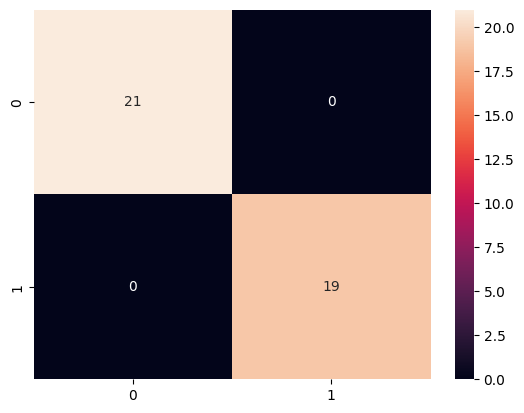

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(labels_test, labels_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()


In [ ]:

num_features = data_resampled.shape
print(num_features)


(200, 1568325)


In [ ]:
# prompt: save data_resampled and labels_rasampled as npy files

import numpy as np
np.save('/content/drive/My Drive/data_resampled.npy', data_resampled)
np.save('/content/drive/My Drive/labels_resampled.npy', labels_resampled)


RANDOM FOREST

In [ ]:
print(features_train.shape)
print(features_test.shape)
print(labels_train.shape)
print(labels_test.shape)

(1640, 25, 62733)
(410, 25, 62733)
(1640,)
(410,)


In [ ]:
print(data_resampled.shape)
print(labels_resampled.shape)


(200, 1568325)
(200,)


In [ ]:

import numpy as np
from sklearn.utils import resample

def check_balanced(data_resampled, labels_resampled):
  # Check if the data is balanced
  unique, counts = np.unique(labels_resampled, return_counts=True)
  for i in range(len(unique)):
    if counts[i] != counts[0]:
      return False
  return True

if check_balanced(data_resampled, labels_resampled):
  print("The data is balanced.")
else:
  print("The data is not balanced.")


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
# Select the most important features
selector = SelectFromModel(estimator=RandomForestClassifier(n_estimators=100, random_state=42)).fit(features_train, labels_train)
features_train_sel = selector.transform(features_train)
features_test_sel = selector.transform(features_test)

# Train the classifier
clf = RandomForestClassifier(n_estimators=200, max_depth=30, random_state=42)
clf.fit(features_train_sel, labels_train)

# Test the classifier
labels_pred = clf.predict(features_test_sel)

# Calculate the accuracy
accuracy = clf.score(features_test_sel, labels_test)

# Use cross-validation to get a more robust estimate of the accuracy
scores = cross_val_score(clf, features_train_sel, labels_train, cv=5)
mean_score = scores.mean()

print(f"Accuracy: {accuracy}")
print(f"Cross-validated Accuracy: {mean_score}")

Accuracy: 0.975
Cross-validated Accuracy: 1.0


In [ ]:
print(features_train)

[[[-0.40085888  0.6452522  -0.9009476  ... -0.4149487   0.10761907
   -0.08503151]
  [-0.59563637  0.68126297 -0.9959221  ... -0.45037222 -0.40242964
   -0.40303862]
  [-0.03613853  0.8716183  -0.94893265 ... -0.4161722  -0.4513593
   -0.16168636]
  ...
  [-0.08979797  0.8934498  -0.97154427 ... -0.22139284  0.12999965
    0.13006246]
  [ 0.35636902  0.5692196  -0.7849369  ... -0.07945365  0.13342644
    0.24056591]
  [ 0.3604927   0.63329697 -0.8618078  ...  0.07795188  0.45672402
    0.58452904]]

 [[-0.247056    0.43439102 -0.83142376 ... -0.1819805   0.64243877
    0.47699246]
  [ 0.25568676  0.4965334  -0.640646   ... -0.09883231  0.5871382
    1.        ]
  [ 0.01247215  0.5641289  -0.8057022  ... -0.14325878  0.6566067
    1.        ]
  ...
  [ 0.23780441  0.7939794  -0.8746438  ... -0.05519751  0.3381107
    0.28746974]
  [ 0.37871742  0.4305129  -0.64762497 ...  0.06973454  0.29647842
    0.77569807]
  [ 0.3049612   0.5281882  -0.78700066 ...  0.04168629  0.00438857
    0.1659

In [ ]:
from imblearn.over_sampling import SMOTE

# Reshape to 2D
features_train_2d = features_train.reshape(features_train.shape[0], -1)

# Use SMOTE
sm = SMOTE(random_state=42)
X_res_2d, y_res = sm.fit_resample(features_train_2d, labels_train)

# Reshape back to 3D
X_res = X_res_2d.reshape(X_res_2d.shape[0], features_train.shape[1], features_train.shape[2])

In [ ]:
print(features_train)
print(features_train.shape)
print(features_test.shape)
print(labels_train.shape)
print(labels_test.shape)

[[[-0.4719677   0.656023   -0.8863964  ...  0.292418   -0.4628145
    0.34362906]
  [ 0.14364624  0.6267977  -0.701746   ...  0.47166356 -0.42196882
    0.66864204]
  [ 0.03935623  0.7020941  -0.83201504 ...  0.6314843  -0.6818775
    0.58989644]
  ...
  [ 0.23505688  0.8623295  -0.9139018  ... -0.11480862 -0.29965392
    0.09852572]
  [ 0.39499187  0.53837204 -0.7659168  ...  0.10011401 -0.21013531
   -0.04850863]
  [ 0.35650158  0.61344767 -0.8629246  ...  0.11057688 -0.08943483
   -0.20417815]]

 [[-0.5526867   0.608696   -0.85675144 ...  0.5841238  -0.06098941
   -0.31834495]
  [ 0.12656975  0.495862   -0.5588417  ...  0.5368992  -0.06137472
   -0.28796095]
  [-0.03493309  0.69756794 -0.84686756 ...  0.47417    -0.38832882
   -0.11671492]
  ...
  [ 0.3337221   0.7075739  -0.92622614 ... -1.          0.19693646
   -0.5856068 ]
  [ 0.7397213  -0.4442587  -0.5325184  ... -0.95830107  0.45428276
   -0.21083036]
  [ 0.21185589  0.3214121  -0.85210323 ... -0.8570854   0.7682496
   -0.385

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

data_flattened = features.reshape(features.shape[0], -1)

# Split data into a training set and a test set
data_train, data_test, labels_train, labels_test = train_test_split(data_flattened, labels, test_size=0.2, random_state=42)

# Create a Random Forest
clf = RandomForestClassifier()

# Define the hyperparameters and their values that you want to tune
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(data_train, labels_train)

# Get the best model
best_clf = grid_search.best_estimator_

# Test the Random Forest
labels_pred = best_clf.predict(data_test)

# Calculate the accuracy and loss
accuracy = best_clf.score(data_test, labels_test)
loss = mean_squared_error(labels_test, labels_pred)

# Calculate the confusion matrix
cm = confusion_matrix(labels_test, labels_pred)

# Plot the accuracy and loss
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(['Accuracy'], [accuracy])
plt.ylim([0, 1])

plt.subplot(1, 2, 2)
plt.bar(['Loss'], [loss])
plt.ylim([0, 1])

plt.show()

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

Fitting 3 folds for each of 216 candidates, totalling 648 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


In [ ]:
print(accuracy)
print(loss)

0.975
0.025


USING ADAM OPTIMISER

In [ ]:
from sklearn.utils import class_weight
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam

# Define the model
model = Sequential()
model.add(LSTM(50, input_shape=(features_train.shape[1], features_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))
# Define your optimizer with a specific learning rate
optimizer = Adam(learning_rate=0.015)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Calculate class weights
class_weights = class_weight.compute_sample_weight('balanced', labels_train)
#class_weights = class_weight.compute_class_weight('balanced', np.unique(labels_train), labels_train)

# Convert class weights to dictionary to work with Keras
class_weights = dict(enumerate(class_weights))

# Train the model
history = model.fit(features_train, labels_train, class_weight=class_weights, epochs=50, batch_size=32)

# Evaluate the model
loss, accuracy = model.evaluate(features_test, labels_test, verbose=0)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

Epoch 1/50
52/52 [==============================] - 17s 277ms/step - loss: 0.1159 - accuracy: 0.9335
Epoch 2/50
52/52 [==============================] - 13s 260ms/step - loss: 0.1067 - accuracy: 0.9506
Epoch 3/50
52/52 [==============================] - 14s 262ms/step - loss: 0.1043 - accuracy: 0.9506
Epoch 4/50
29/52 [===============>..............] - ETA: 5s - loss: 0.1048 - accuracy: 0.9504

KeyboardInterrupt: 

SGD OPTIMISER

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten
from keras.optimizers import Adam,SGD

# Define the model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(features_train.shape[1], features_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(50))
model.add(Dense(1, activation='sigmoid'))

# Define your optimizer with a specific learning rate
optimizer = SGD(learning_rate=0.015)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Calculate class weights
class_weights = class_weight.compute_sample_weight('balanced', labels_train)

# Convert class weights to dictionary to work with Keras
class_weights = dict(enumerate(class_weights))

# Train the model
history = model.fit(features_train, labels_train, class_weight=class_weights, epochs=50, batch_size=32)

# Evaluate the model
loss, accuracy = model.evaluate(features_test, labels_test, verbose=0)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

Epoch 1/50
52/52 [==============================] - 32s 464ms/step - loss: 0.1076 - accuracy: 0.9311
Epoch 2/50
52/52 [==============================] - 22s 427ms/step - loss: 0.0703 - accuracy: 0.9494
Epoch 3/50
52/52 [==============================] - 26s 496ms/step - loss: 0.0523 - accuracy: 0.9500
Epoch 4/50
52/52 [==============================] - 25s 481ms/step - loss: 0.0443 - accuracy: 0.9506
Epoch 5/50
52/52 [==============================] - 25s 488ms/step - loss: 0.0368 - accuracy: 0.9506
Epoch 6/50
52/52 [==============================] - 24s 459ms/step - loss: 0.0325 - accuracy: 0.9506
Epoch 7/50
52/52 [==============================] - 27s 510ms/step - loss: 0.0287 - accuracy: 0.9598
Epoch 8/50
52/52 [==============================] - 24s 451ms/step - loss: 0.0257 - accuracy: 0.9927
Epoch 9/50
52/52 [==============================] - 24s 457ms/step - loss: 0.0234 - accuracy: 0.9988
Epoch 10/50
52/52 [==============================] - 25s 491ms/step - loss: 0.0216 - accura

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Predict the classes
predicted_probs = model.predict(features_test)
predicted_classes = np.round(predicted_probs)

# Generate the confusion matrix
cm = confusion_matrix(labels_test, predicted_classes)

# Print the confusion matrix
print('Confusion Matrix:')
print(cm)

13/13 [==============================] - 1s 51ms/step
Confusion Matrix:
[[ 17   1]
 [  1 391]]


In [ ]:
print(features_test.shape)

(410, 25, 62733)


13/13 [==============================] - 1s 51ms/step


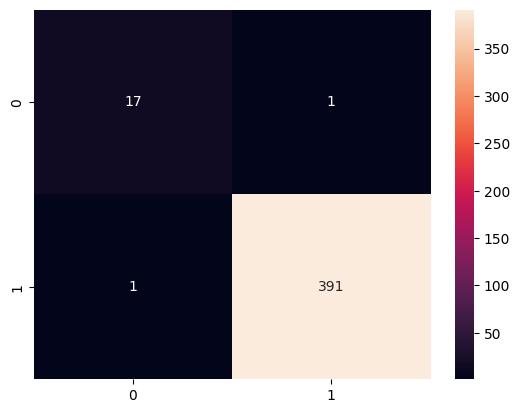

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Predict the classes
predicted_probs = model.predict(features_test)
predicted_classes = np.round(predicted_probs)

cm = confusion_matrix(labels_test, predicted_classes)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

In [ ]:

model.save('my_model.keras')


In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(features_test, labels_test, verbose=0)

print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

Test Loss: 0.19447337090969086
Test Accuracy: 0.9512194991111755


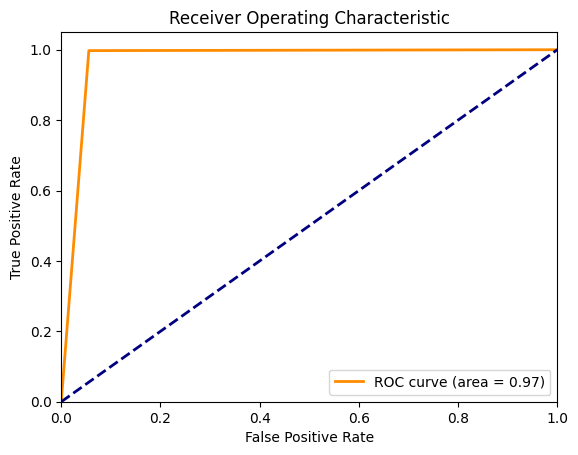

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(labels_test, predicted_classes)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

ADAGRAD OPTIMISER USED

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten
from keras.optimizers import Adagrad
from keras.callbacks import EarlyStopping

# Define the model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(features_train.shape[1], features_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(50))
model.add(Dense(1, activation='sigmoid'))

# Define optimizer with a specific learning rate
optimizer = Adagrad(learning_rate=0.005)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Calculate class weights
class_weights = class_weight.compute_sample_weight('balanced', labels_train)

# Convert class weights to dictionary to work with Keras
class_weights = dict(enumerate(class_weights))

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Train the model
history1 = model.fit(features_train, labels_train, class_weight=class_weights, epochs=50, batch_size=32, callbacks=[early_stopping], validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(features_test, labels_test, verbose=0)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

Epoch 1/50
41/41 [==============================] - 23s 518ms/step - loss: 0.1217 - accuracy: 0.9436 - val_loss: 0.1864 - val_accuracy: 0.9512
Epoch 2/50
41/41 [==============================] - 21s 510ms/step - loss: 0.0914 - accuracy: 0.9489 - val_loss: 0.1503 - val_accuracy: 0.9512
Epoch 3/50
41/41 [==============================] - 22s 533ms/step - loss: 0.0771 - accuracy: 0.9489 - val_loss: 0.1134 - val_accuracy: 0.9512
Epoch 4/50
41/41 [==============================] - 20s 493ms/step - loss: 0.0534 - accuracy: 0.9497 - val_loss: 0.0892 - val_accuracy: 0.9878
Epoch 5/50
41/41 [==============================] - 19s 466ms/step - loss: 0.0423 - accuracy: 0.9870 - val_loss: 0.0719 - val_accuracy: 0.9939
Epoch 6/50
41/41 [==============================] - 20s 483ms/step - loss: 0.0353 - accuracy: 0.9947 - val_loss: 0.0614 - val_accuracy: 0.9970
Epoch 7/50
41/41 [==============================] - 20s 494ms/step - loss: 0.0305 - accuracy: 0.9954 - val_loss: 0.0553 - val_accuracy: 0.9970

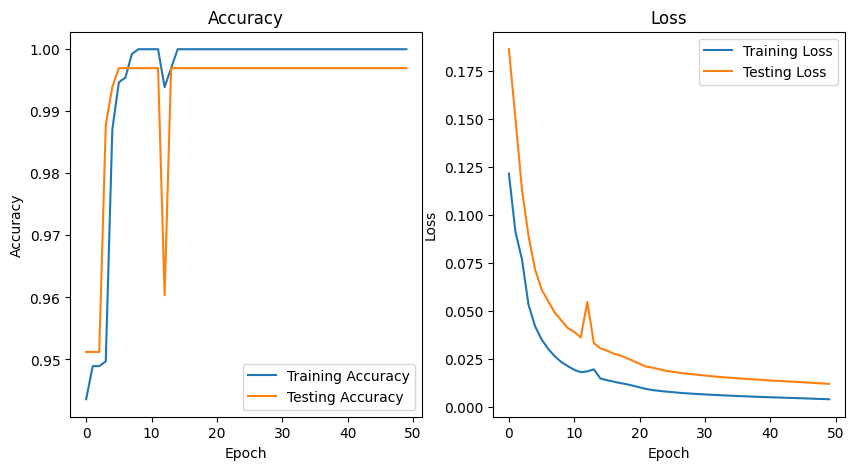

In [ ]:

import matplotlib.pyplot as plt
# Plot the accuracy and loss curves
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Testing Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Testing Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


13/13 [==============================] - 1s 53ms/step


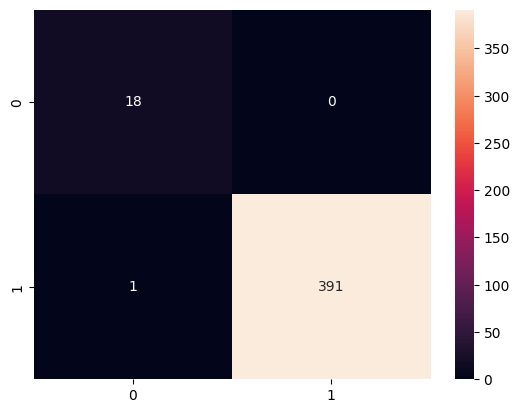

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Predict the classes
predicted_probs = model.predict(features_test)
predicted_classes = np.round(predicted_probs)

cm = confusion_matrix(labels_test, predicted_classes)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

true_labels = labels_test
predictions = predicted_classes
# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)
auc_roc = roc_auc_score(true_labels, predictions)

# Print metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'AUC-ROC: {auc_roc}')

# Calculate and print confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)
print(f'Confusion Matrix: \n{conf_matrix}')

Accuracy: 0.9975609756097561
Precision: 1.0
Recall: 0.9974489795918368
F1 Score: 0.9987228607918263
AUC-ROC: 0.9987244897959184
Confusion Matrix: 
[[ 18   0]
 [  1 391]]


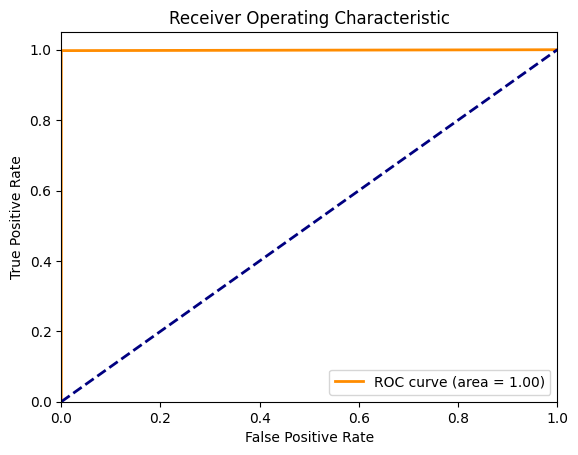

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(labels_test, predicted_classes)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:

model.save('my_model_adagrad.keras')

In [ ]:
print(len(labels_test))
print(len(labels_pred))

410
40


ADAGRAD WITH REGULARISATION

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Dropout
from keras.optimizers import Adagrad
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

# Define the model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(features_train.shape[1], features_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))  # Dropout layer
model.add(LSTM(50, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))  # Regularization
model.add(Dropout(0.5))  # Dropout layer
model.add(Dense(1, activation='sigmoid'))

# Define your optimizer with a specific learning rate
optimizer = Adagrad(learning_rate=0.015)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Calculate class weights
class_weights = class_weight.compute_sample_weight('balanced', labels_train)

# Convert class weights to dictionary to work with Keras
class_weights = dict(enumerate(class_weights))

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Train the model
history1 = model.fit(features_train, labels_train, class_weight=class_weights, epochs=20, batch_size=32, callbacks=[early_stopping], validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(features_test, labels_test, verbose=0)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

Epoch 1/20
41/41 [==============================] - 25s 542ms/step - loss: 2.0348 - accuracy: 0.9497 - val_loss: 2.0218 - val_accuracy: 0.9512
Epoch 2/20
41/41 [==============================] - 19s 469ms/step - loss: 1.8805 - accuracy: 0.9489 - val_loss: 1.8910 - val_accuracy: 0.9512
Epoch 3/20
41/41 [==============================] - 20s 482ms/step - loss: 1.7498 - accuracy: 0.9482 - val_loss: 1.7605 - val_accuracy: 0.9512
Epoch 4/20
41/41 [==============================] - 17s 423ms/step - loss: 1.6343 - accuracy: 0.9489 - val_loss: 1.6240 - val_accuracy: 0.9512
Epoch 5/20
41/41 [==============================] - 18s 432ms/step - loss: 1.5278 - accuracy: 0.9489 - val_loss: 1.5436 - val_accuracy: 0.9512
Epoch 6/20
41/41 [==============================] - 19s 453ms/step - loss: 1.4220 - accuracy: 0.9489 - val_loss: 1.4156 - val_accuracy: 0.9512
Epoch 7/20
41/41 [==============================] - 19s 462ms/step - loss: 1.3175 - accuracy: 0.9489 - val_loss: 1.3220 - val_accuracy: 0.9512

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

true_labels = labels_test
predictions = predicted_classes
# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)
auc_roc = roc_auc_score(true_labels, predictions)

# Print metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'AUC-ROC: {auc_roc}')

# Calculate and print confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)
print(f'Confusion Matrix: \n{conf_matrix}')

Accuracy: 0.9975609756097561
Precision: 1.0
Recall: 0.9974489795918368
F1 Score: 0.9987228607918263
AUC-ROC: 0.9987244897959184
Confusion Matrix: 
[[ 18   0]
 [  1 391]]


13/13 [==============================] - 1s 53ms/step


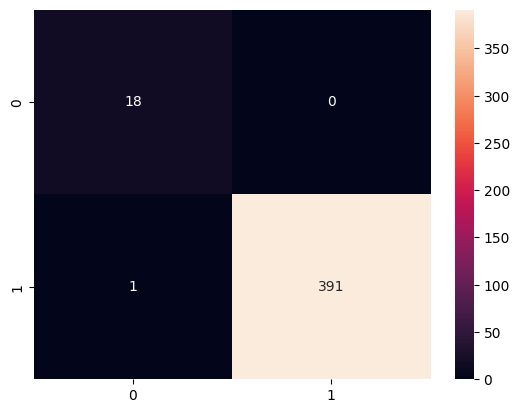

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Predict the classes
predicted_probs = model.predict(features_test)
predicted_classes = np.round(predicted_probs)

cm = confusion_matrix(labels_test, predicted_classes)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved weights into the model
model.load_weights('my_model_weights.h5')

# Continue training the model
model.fit(features_train, labels_train, epochs=50, batch_size=32)

# Save the model weights again after training
model.save_weights('my_model_weights.h5')

In [ ]:
print(features_over.shape)

(3900, 1568325)


BEST MODEL AS OF NOW

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Dropout
from keras.optimizers import SGD
from keras.regularizers import l2
from sklearn.utils import class_weight

# Define the model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01), input_shape=(features_over.shape[1], features_over.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.7))
model.add(LSTM(25, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.7))
model.add(Dense(1, activation='sigmoid'))

# Define your optimizer with a specific learning rate
optimizer = SGD(learning_rate=0.015)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Calculate class weights
class_weights = class_weight.compute_sample_weight('balanced', labels_train)

# Convert class weights to dictionary to work with Keras
class_weights = dict(enumerate(class_weights))

# Train the model for 20 epochs
history = model.fit(features_train, labels_train, epochs=20, validation_split=0.2, batch_size=32)

# Evaluate the model
loss, accuracy = model.evaluate(features_test, labels_test, verbose=0)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

Epoch 1/20
78/78 [==============================] - 36s 442ms/step - loss: 1.8495 - accuracy: 0.5192 - val_loss: 1.8277 - val_accuracy: 0.4968
Epoch 2/20
78/78 [==============================] - 27s 349ms/step - loss: 1.7771 - accuracy: 0.5176 - val_loss: 1.7569 - val_accuracy: 0.0304
Epoch 3/20
78/78 [==============================] - 29s 371ms/step - loss: 1.6995 - accuracy: 0.5597 - val_loss: 1.6749 - val_accuracy: 0.4808
Epoch 4/20
78/78 [==============================] - 28s 357ms/step - loss: 1.6070 - accuracy: 0.6238 - val_loss: 1.6138 - val_accuracy: 0.6923
Epoch 5/20
78/78 [==============================] - 29s 375ms/step - loss: 1.5408 - accuracy: 0.6783 - val_loss: 1.5266 - val_accuracy: 0.9615
Epoch 6/20
78/78 [==============================] - 30s 380ms/step - loss: 1.4803 - accuracy: 0.7031 - val_loss: 1.5062 - val_accuracy: 0.5481
Epoch 7/20
78/78 [==============================] - 28s 352ms/step - loss: 1.3814 - accuracy: 0.7680 - val_loss: 1.5370 - val_accuracy: 0.5016

In [ ]:

model.save('my_model_sgd_dropout.keras')

25/25 [==============================] - 1s 36ms/step


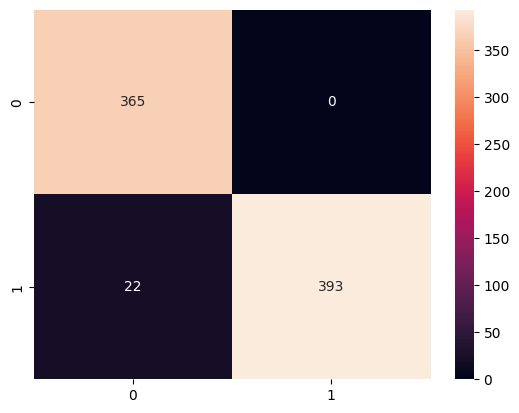

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Predict the classes
predicted_probs = model.predict(features_test)
predicted_classes = np.round(predicted_probs)

cm = confusion_matrix(labels_test, predicted_classes)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

In [ ]:
print(features_test.shape)


(780, 25, 62733)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

true_labels = labels_test
predictions = predicted_classes
# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)
auc_roc = roc_auc_score(true_labels, predictions)

# Print metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'AUC-ROC: {auc_roc}')

# Calculate and print confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)
print(f'Confusion Matrix: \n{conf_matrix}')

Accuracy: 0.9717948717948718
Precision: 1.0
Recall: 0.946987951807229
F1 Score: 0.9727722772277227
AUC-ROC: 0.9734939759036145
Confusion Matrix: 
[[365   0]
 [ 22 393]]


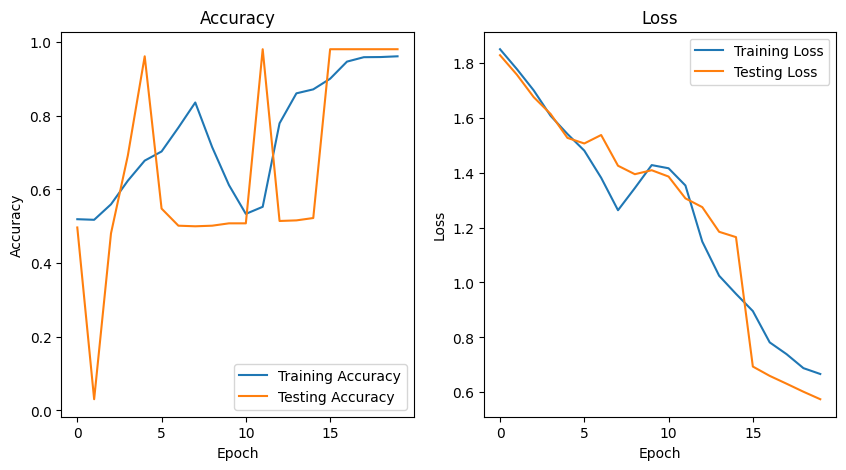

In [ ]:

import matplotlib.pyplot as plt
# Plot the accuracy and loss curves
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Testing Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

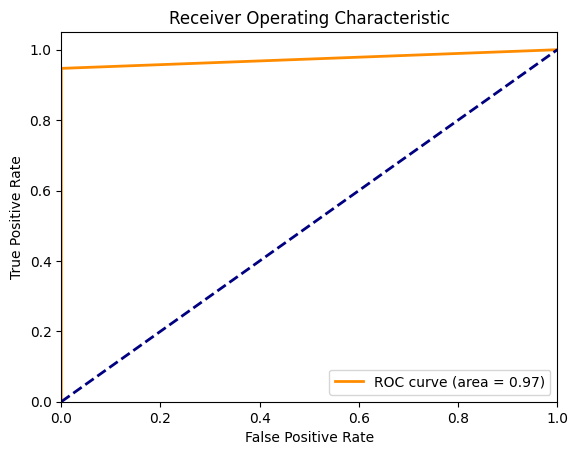

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(labels_test, predicted_classes)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

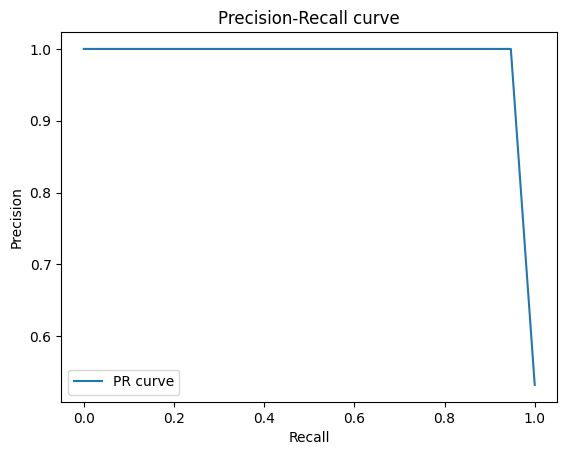

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(labels_test, predicted_classes)

plt.figure()
plt.plot(recall, precision, label='PR curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='best')
plt.show()